In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.scDEED as scd
import BacSC.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/MPA_energy_stress"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 6900 × 29765
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [4]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/2959
Aggregating feature 200/2959
Aggregating feature 300/2959
Aggregating feature 400/2959
Aggregating feature 500/2959
Aggregating feature 600/2959
Aggregating feature 700/2959
Aggregating feature 800/2959
Aggregating feature 900/2959
Aggregating feature 1000/2959
Aggregating feature 1100/2959
Aggregating feature 1200/2959
Aggregating feature 1300/2959
Aggregating feature 1400/2959
Aggregating feature 1500/2959
Aggregating feature 1600/2959
Aggregating feature 1700/2959
Aggregating feature 1800/2959
Aggregating feature 1900/2959
Aggregating feature 2000/2959
Aggregating feature 2100/2959
Aggregating feature 2200/2959
Aggregating feature 2300/2959
Aggregating feature 2400/2959
Aggregating feature 2500/2959
Aggregating feature 2600/2959
Aggregating feature 2700/2959
Aggregating feature 2800/2959
Aggregating feature 2900/2959


AnnData object with n_obs × n_vars = 6900 × 2959
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.991
Zero inflation of aggregated data: 0.935


### Filter cells

--> filter based on mean absolute standard deviation

In [6]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=10, min_cells=2, min_genes=100)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    6707
True      193
Name: outlier, dtype: int64
Total number of cells: 6900
Number of cells after filtering: 6703


AnnData object with n_obs × n_vars = 6703 × 2937
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

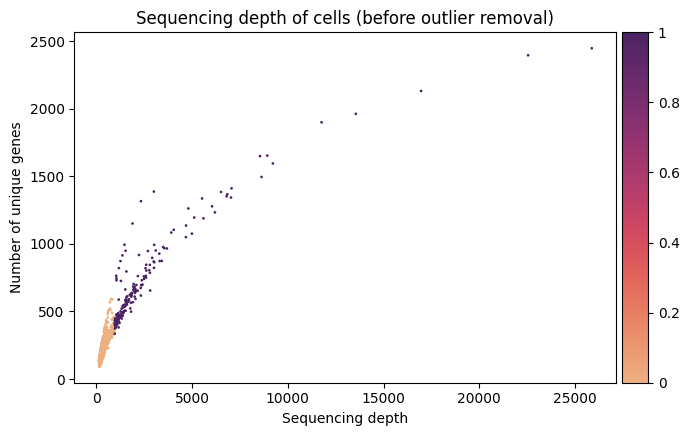

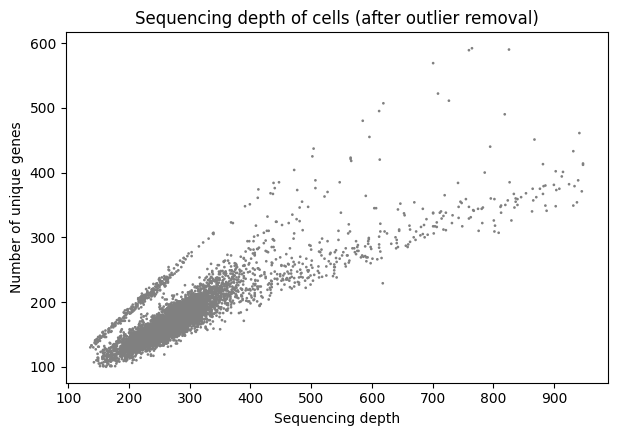

In [7]:
g = sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [8]:
data_gene.layers["counts"] = data_gene.X.copy()

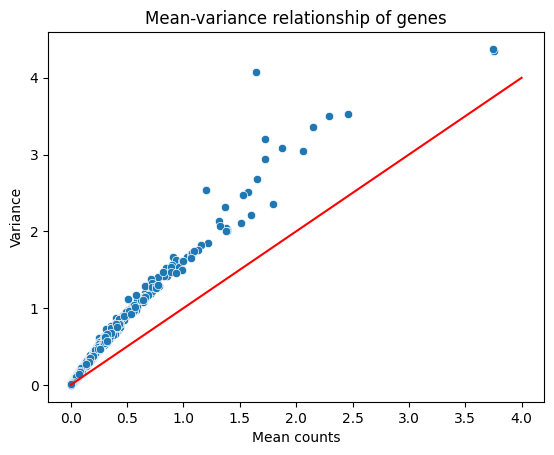

In [9]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [10]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

False


## Estimate negative binomial parameters for each gene

In [11]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=1234)

In [12]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
Sr1   Gene Expression   PA01                  9     0.001343   
aadK  Gene Expression   PA01                155     0.034611   
aag   Gene Expression   PA01                 18     0.003282   
aapA  Gene Expression   PA01                 65     0.013874   
abbA  Gene Expression   PA01                285     0.066388   
...               ...    ...                ...          ...   
znuB  Gene Expression   PA01                 71     0.014322   
znuC  Gene Expression   PA01                 21     0.003879   
zosA  Gene Expression   PA01                319     0.069372   
zur   Gene Expression   PA01                 35     0.006415   
zwf   Gene Expression   PA01               1770     0.407131   

      log1p_mean_counts  pct_dropout_by_counts  total_counts  \
Sr1            0.001342              99.865732           9.0   
aadK           0.034026              97.687603         232.0   
aag            0.003277              99.731464          22.0   
aapA           0.013779              99.030285          93.0   
abbA           0.064277              95.748172         445.0   
...                 ...                    ...           ...   
znuB           0.014220              98.940773          96.0   
znuC           0.003871              99.686707          26.0   
zosA           0.067071              95.240937         465.0   
zur            0.006395              99.477846          43.0   
zwf            0.341553              73.593913        2729.0   

      log1p_total_counts  n_cells  var_counts  is_scd_outlier  nb_overdisp  \
Sr1             2.302585        9    0.001341           False     0.003503   
aadK            5.451038      155    0.075186           False     0.040881   
aag             3.135494       18    0.005062           False     0.006724   
aapA            4.543295       65    0.029794           False     0.018329   
abbA            6.100319      285    0.153283           False     0.074853   
...                  ...      ...         ...             ...          ...   
znuB            4.574711       71    0.027245           False     0.019261   
znuC            3.295837       21    0.005356           False     0.007834   
zosA            6.144186      319    0.144225           False     0.080687   
zur             3.784190       35    0.009358           False     0.011111   
zwf             7.912057     1770    0.748313           False     0.584010   

      nb_overdisp_cutoff    nb_mean    nb_umi  Intercept_step1_sct  \
Sr1             0.010000 -10.340848  1.533455           -19.879982   
aadK            0.040881  -9.716195  2.573962           -11.784379   
aag             0.010000 -10.514442  1.947939           -14.197864   
aapA            0.018329 -10.346963  2.458006                  NaN   
abbA            0.074853  -9.043779  2.561444           -11.532861   
...                  ...        ...       ...                  ...   
znuB            0.019261 -10.314600  2.470299            -4.102008   
znuC            0.010000 -10.590997  2.053894            -6.231503   
zosA            0.080687  -8.941409  2.551356            -9.312267   
zur             0.011111 -10.711728  2.315311                  NaN   
zwf             0.584010  -6.659524  2.348303            -7.542399   

      log_umi_step1_sct  dispersion_step1_sct  
Sr1            5.339636              0.006108  
aadK           3.418825              0.189736  
aag            3.441973              0.095260  
aapA                NaN                   NaN  
abbA           3.578864              0.203239  
...                 ...                   ...  
znuB          -0.059092              0.164263  
znuC           0.278596              0.121542  
zosA           2.704689              0.180779  
zur                 NaN                   NaN  
zwf            2.704602              0.151235  

[2937 rows x 18 columns]

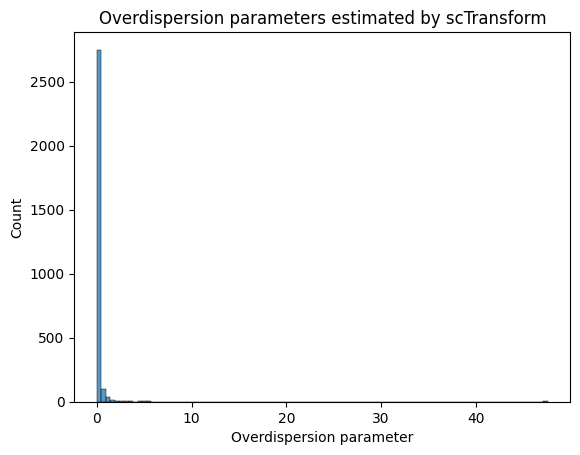

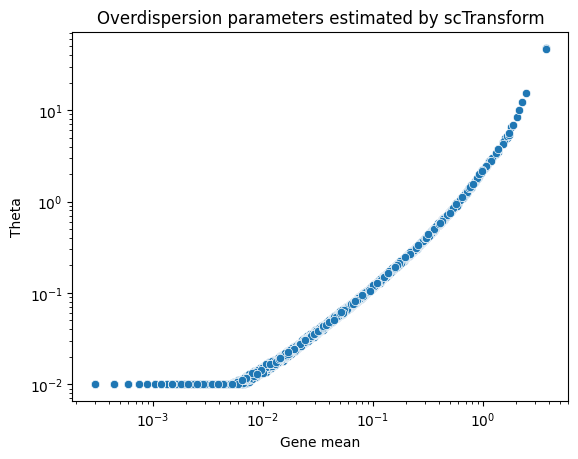

In [13]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [14]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [15]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

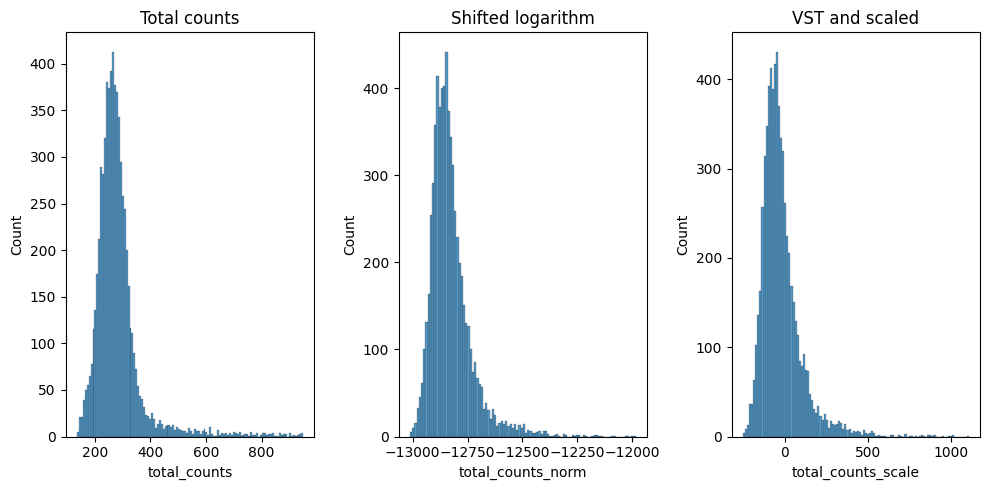

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [17]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 6703 × 2890
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'


In [18]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

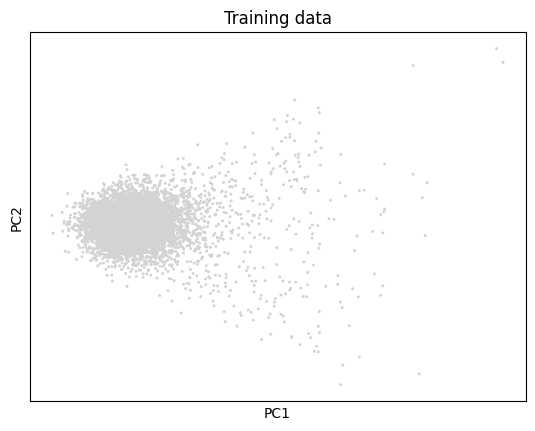

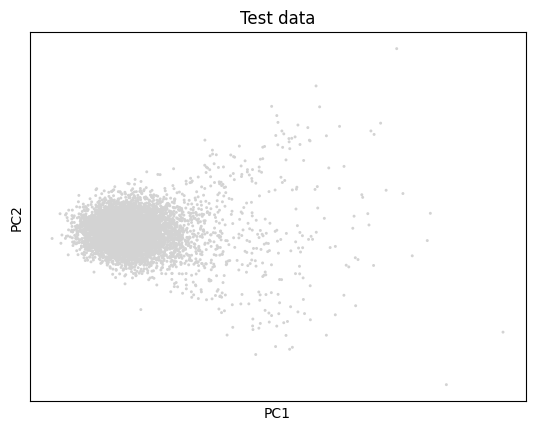

In [19]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [20]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:2


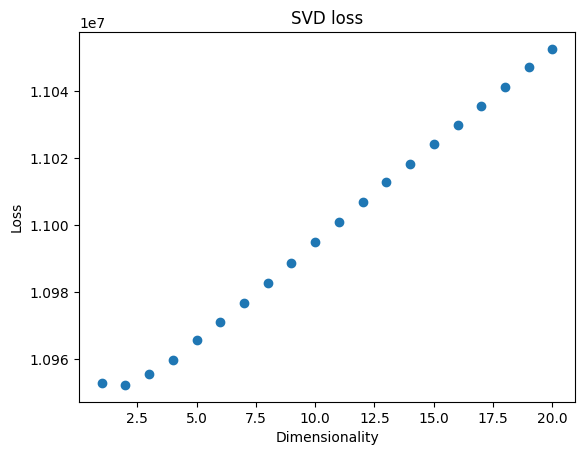

In [21]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

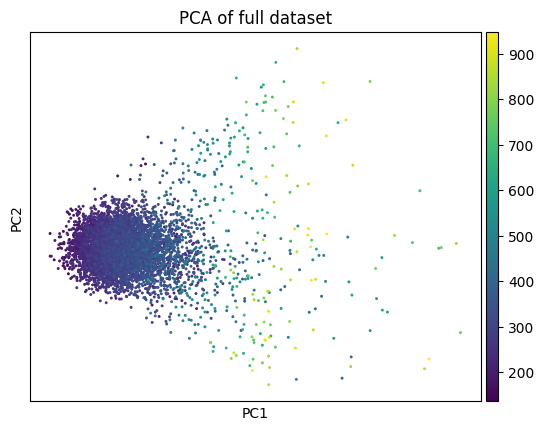

In [49]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [23]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [24]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

929


In [25]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="MPA_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 10
Optimal min_dist: 0.05


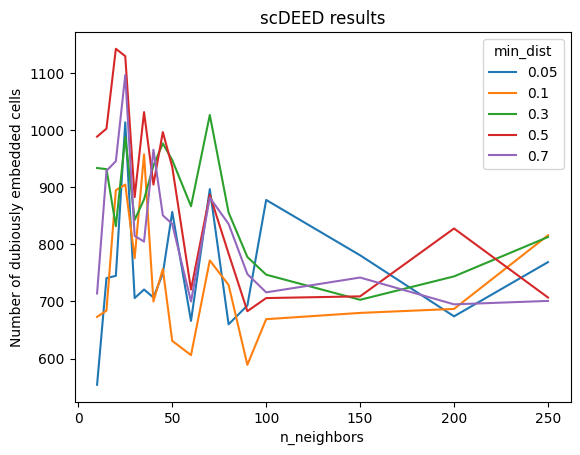

In [26]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [27]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


In [28]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [29]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


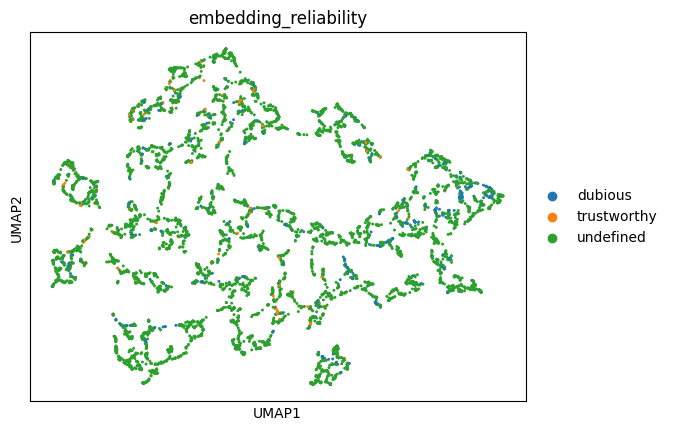

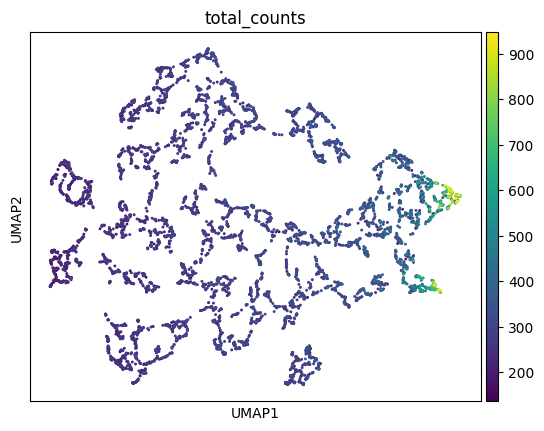

In [30]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [31]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [32]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

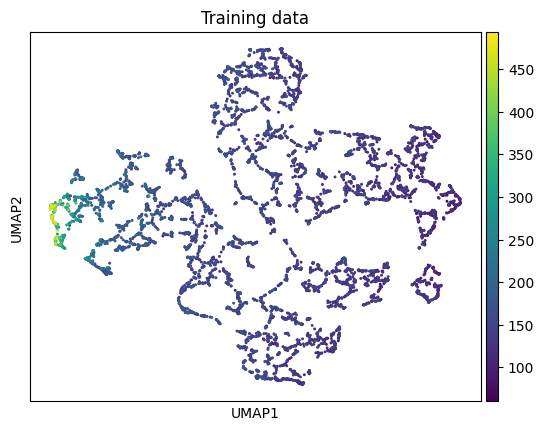

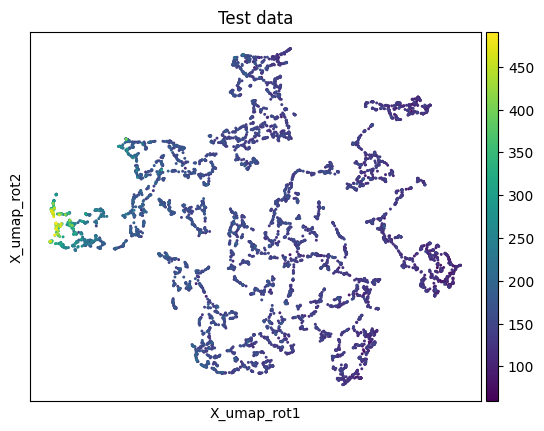

In [33]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [34]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=1234)

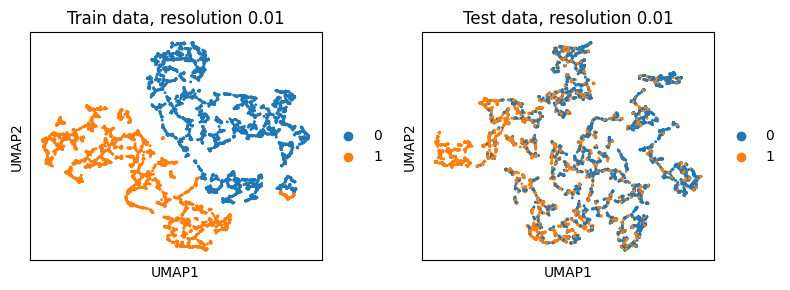

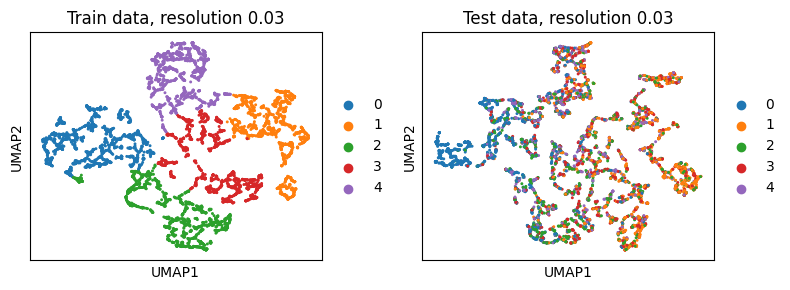

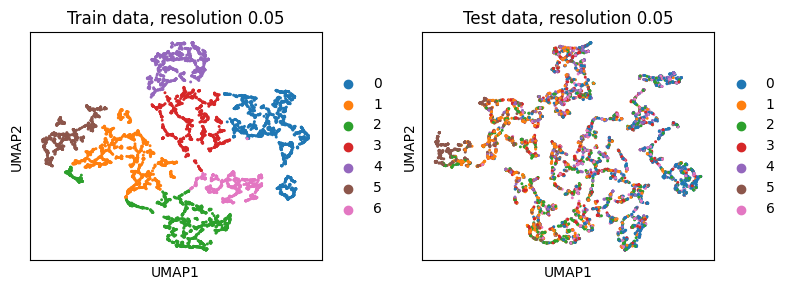

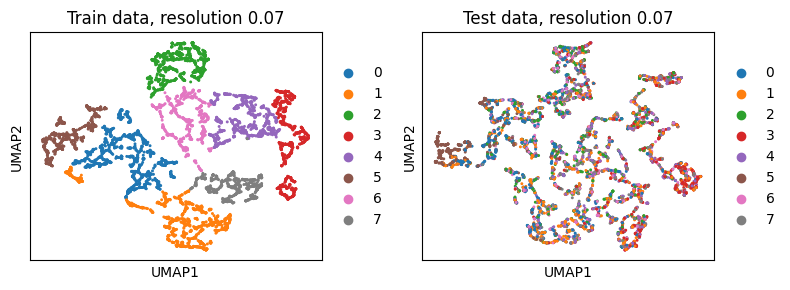

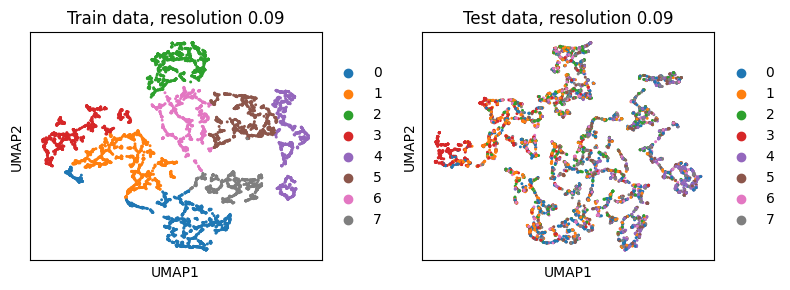

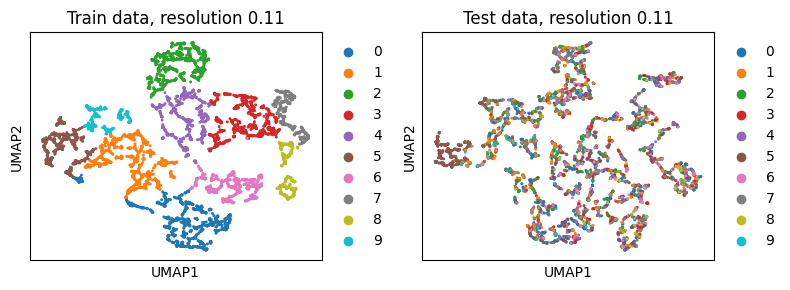

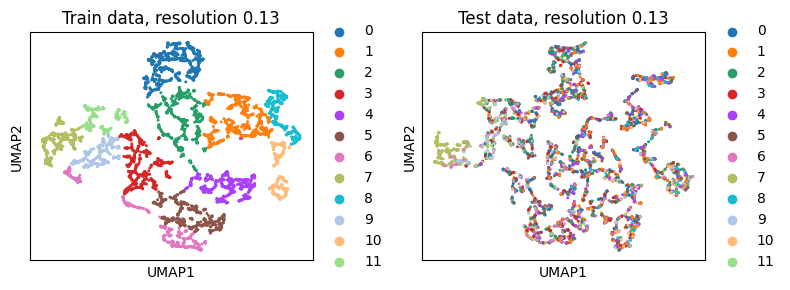

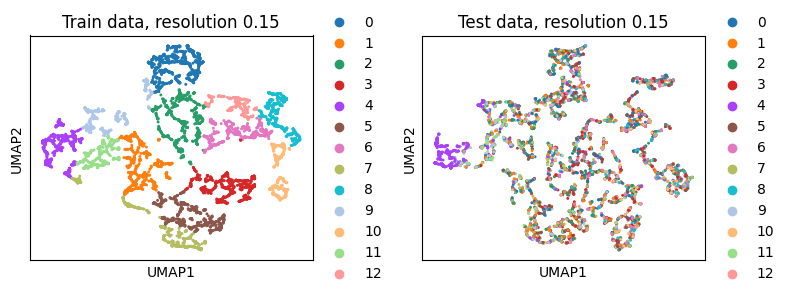

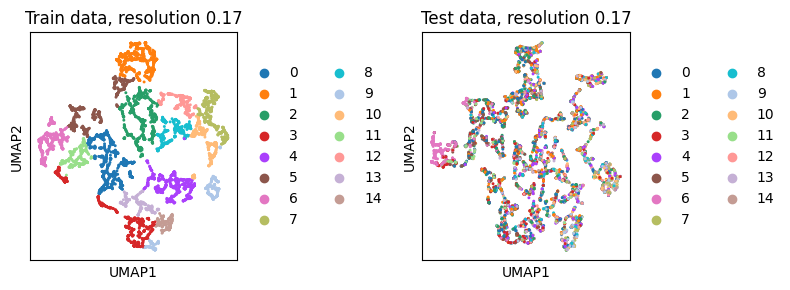

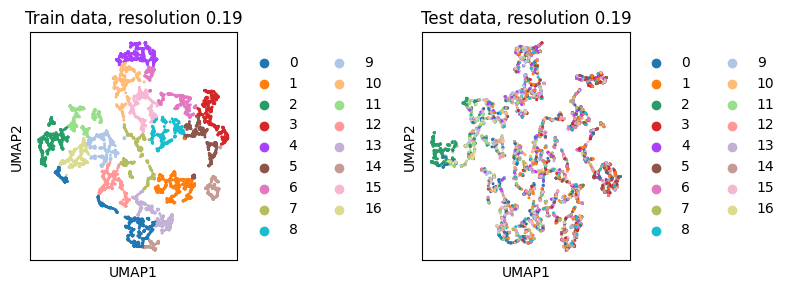

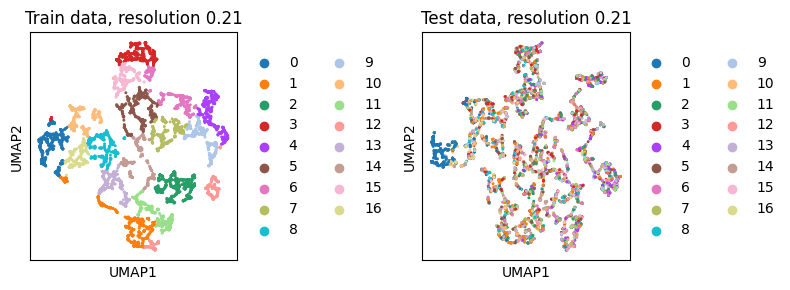

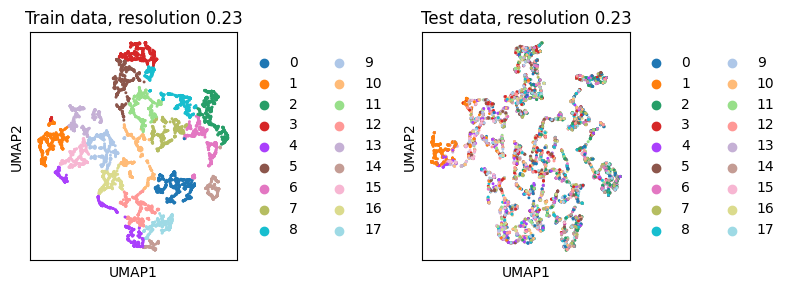

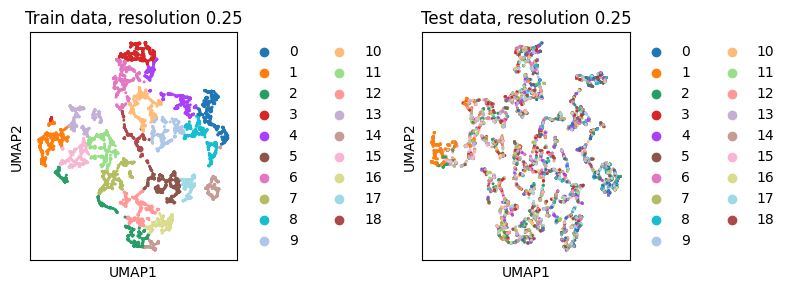

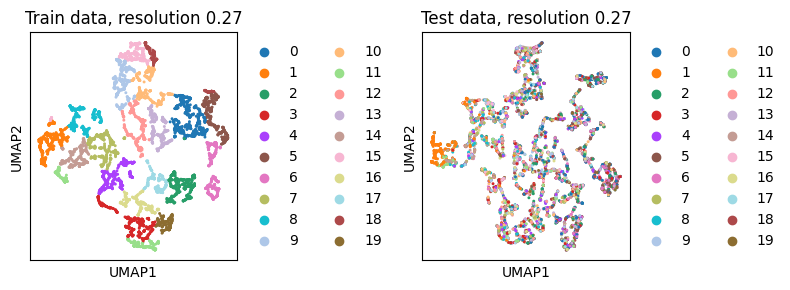

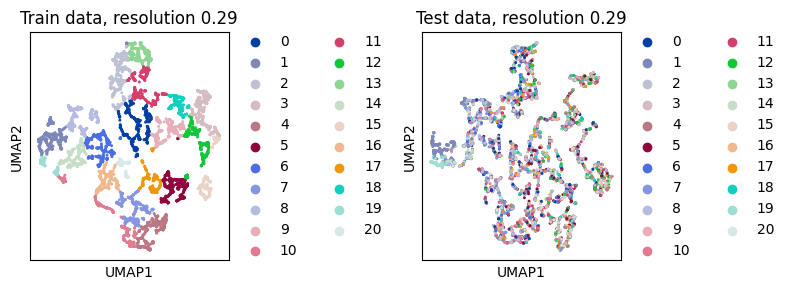

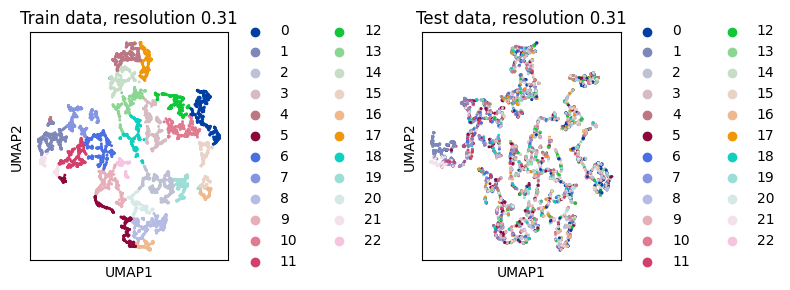

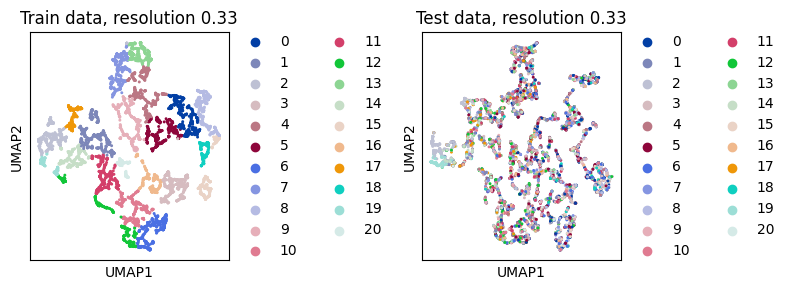

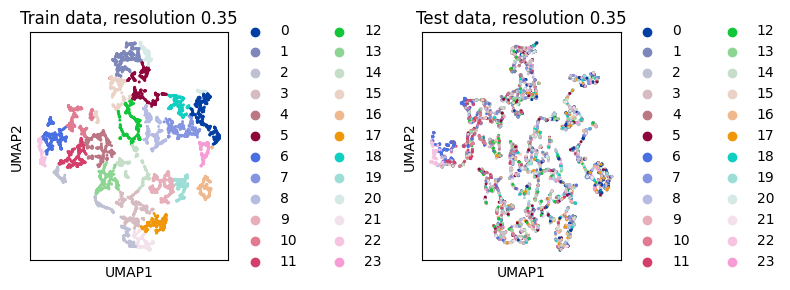

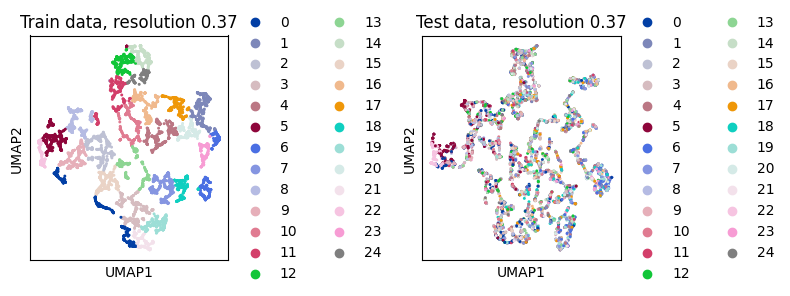

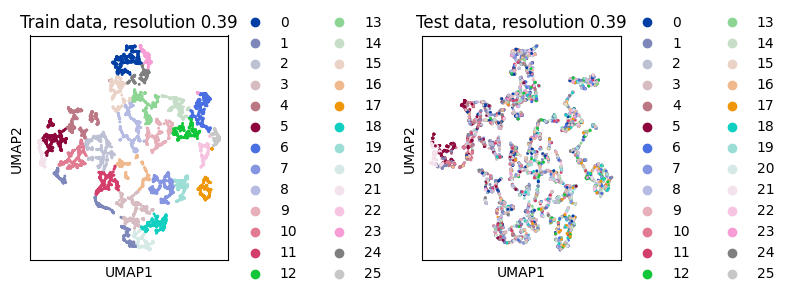

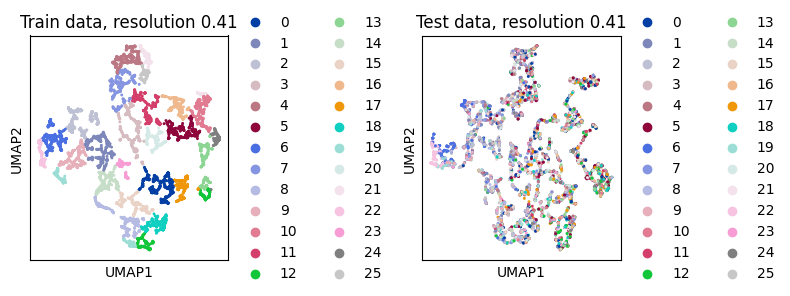

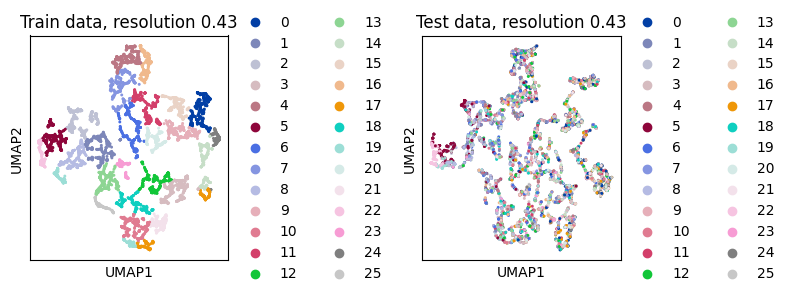

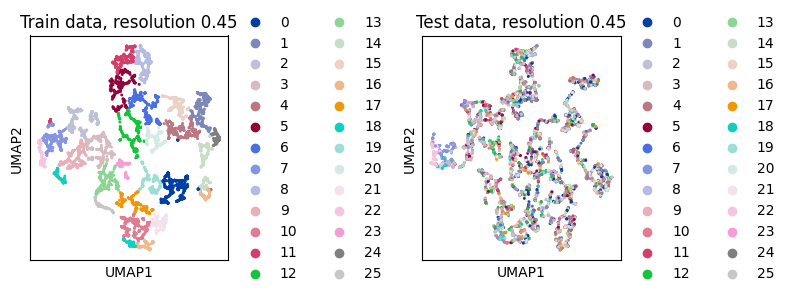

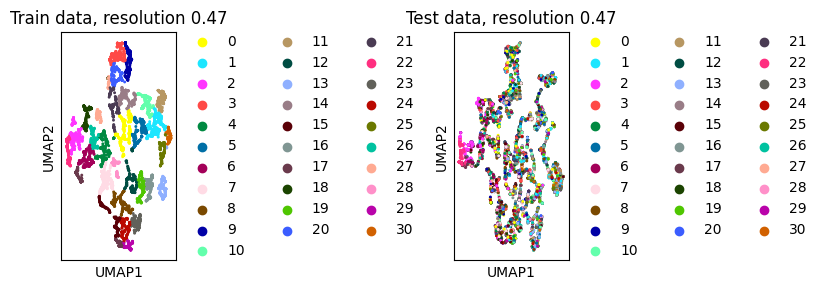

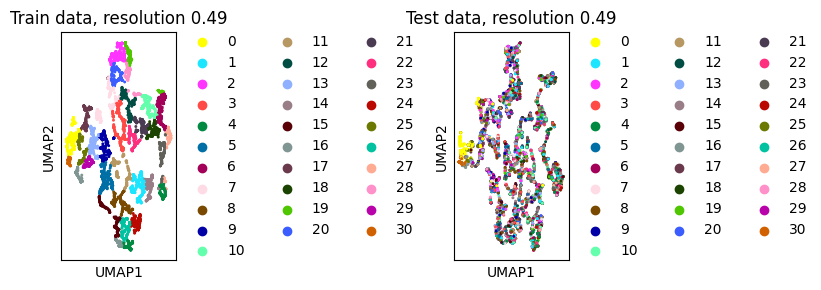

In [35]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [36]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, random_seed=1234)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 2 - Train: 0.491 - Test: 0.299 - Random: 0.246
resolution: 0.03 - clusters: 5 - Train: 0.485 - Test: 0.151 - Random: 0.096
resolution: 0.05 - clusters: 7 - Train: 0.482 - Test: 0.12 - Random: 0.069
resolution: 0.07 - clusters: 8 - Train: 0.479 - Test: 0.103 - Random: 0.058
resolution: 0.09 - clusters: 8 - Train: 0.477 - Test: 0.098 - Random: 0.053
resolution: 0.11 - clusters: 10 - Train: 0.475 - Test: 0.087 - Random: 0.042
resolution: 0.13 - clusters: 12 - Train: 0.473 - Test: 0.071 - Random: 0.034
resolution: 0.15 - clusters: 13 - Train: 0.472 - Test: 0.068 - Random: 0.028
resolution: 0.17 - clusters: 15 - Train: 0.47 - Test: 0.06 - Random: 0.024
resolution: 0.19 - clusters: 17 - Train: 0.469 - Test: 0.054 - Random: 0.018
resolution: 0.21 - clusters: 17 - Train: 0.468 - Test: 0.056 - Random: 0.018
resolution: 0.23 - clusters: 18 - Train: 0.467 - Test: 0.05 - Random: 0.015
resolution: 0.25 - clusters: 19 - Train: 0.466 - Test: 0.048 - Random: 0.015
resoluti

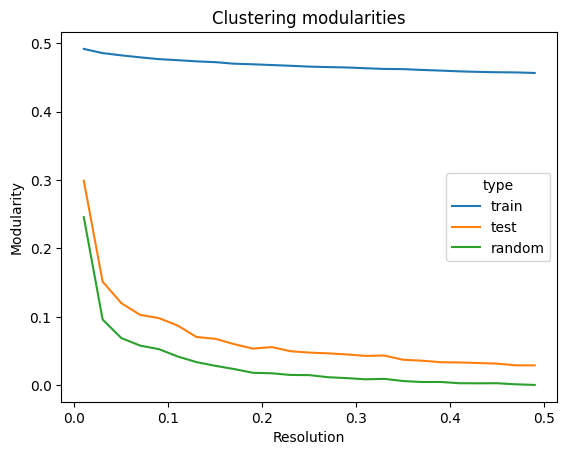

In [37]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

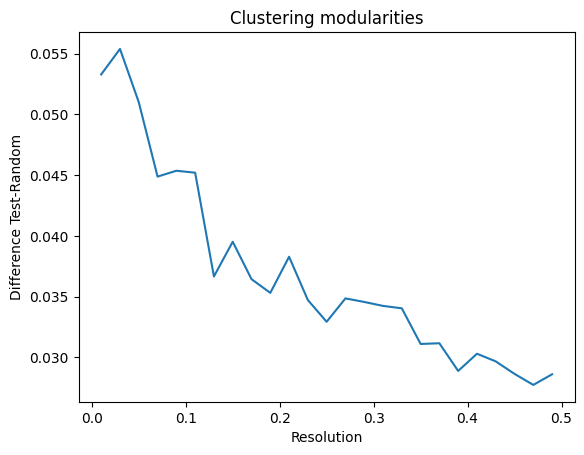

In [38]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [39]:
result_path = "MPA_clustering"
if not os.path.exists(result_path):
    os.makedirs(result_path)
    
mod_df.to_csv(result_path + "/modularities.csv")
mod_df_wide.to_csv(result_path + "/modularities_wide.csv")

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [40]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

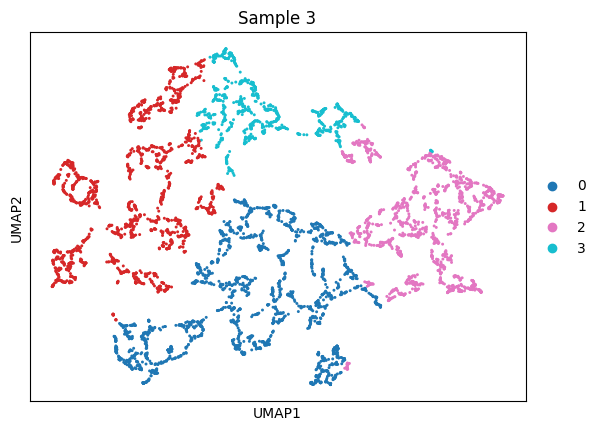

In [41]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [42]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")

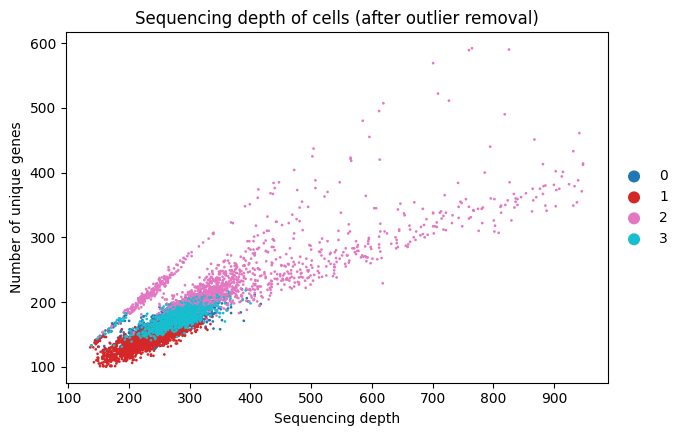

In [43]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

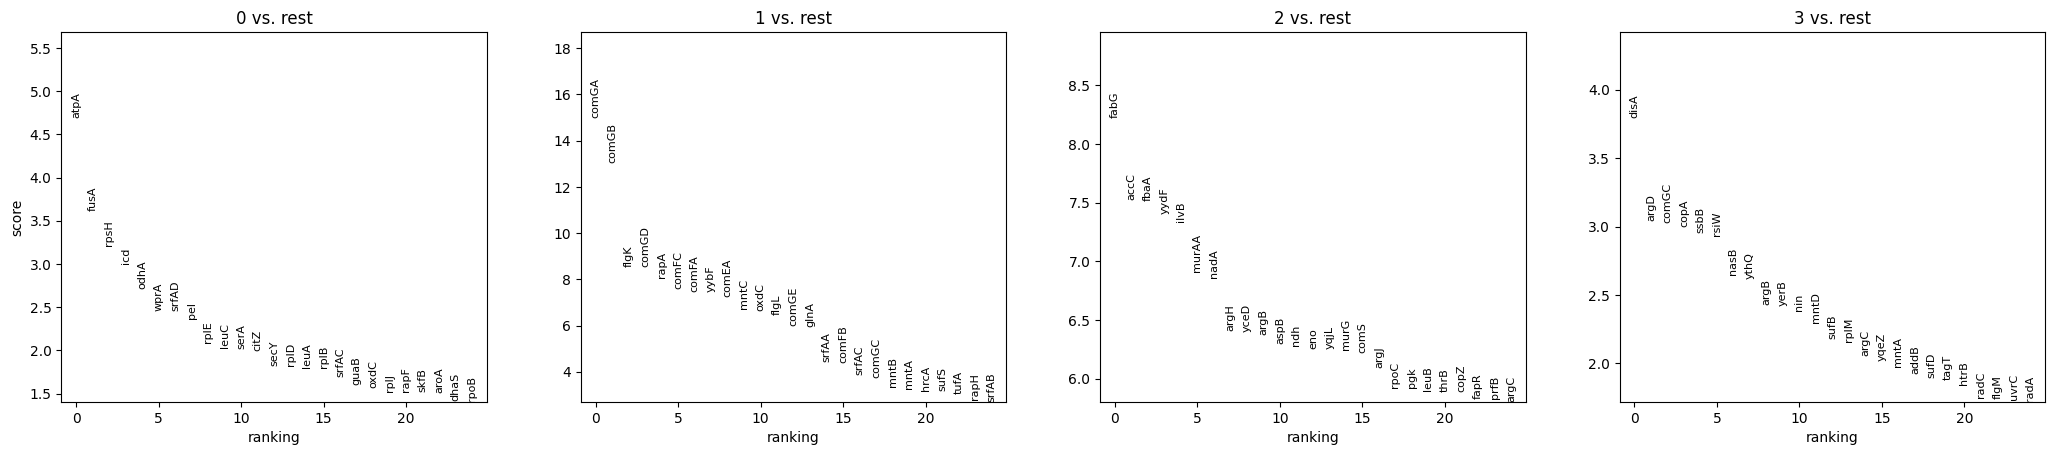

In [44]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

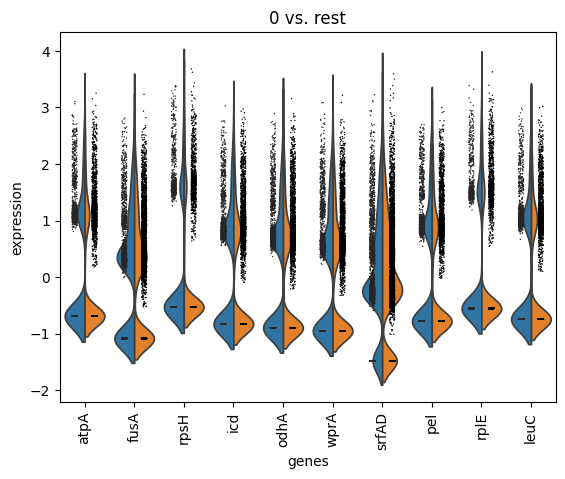

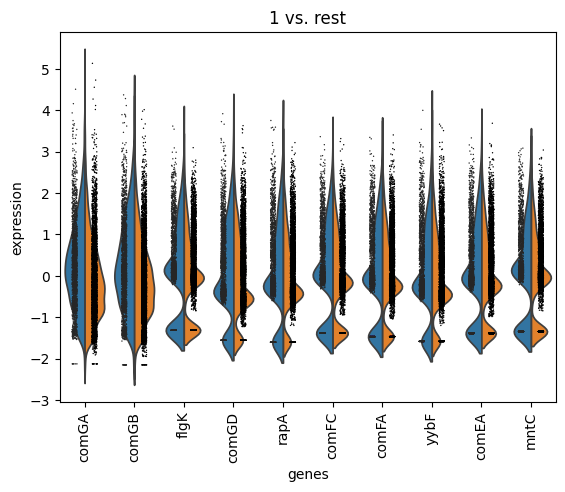

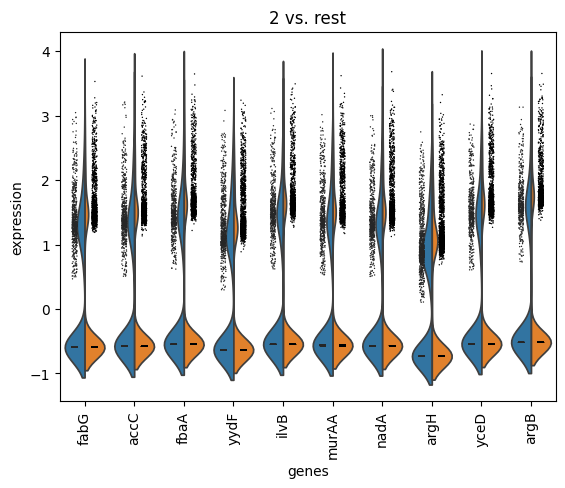

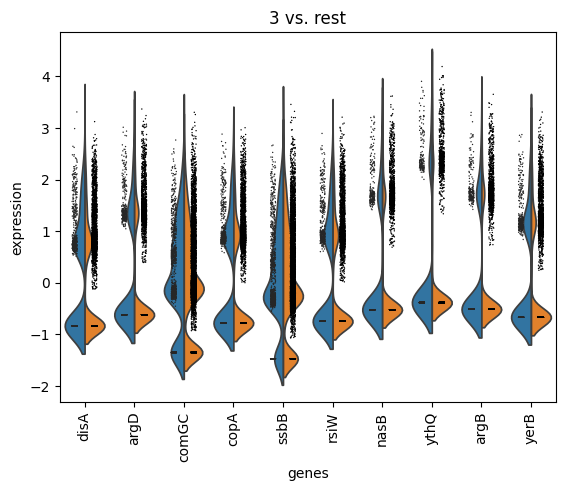

In [45]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

In [46]:
data_gene.layers["counts"]

<6703x2937 sparse matrix of type '<class 'numpy.float64'>'
	with 1183003 stored elements in Compressed Sparse Row format>

In [47]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/MPA_energy_stress"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")
data_gene

AnnData object with n_obs × n_vars = 6703 × 2937
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [48]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
Sr1   Gene Expression   PA01                  9     0.001343   
aadK  Gene Expression   PA01                155     0.034611   
aag   Gene Expression   PA01                 18     0.003282   
aapA  Gene Expression   PA01                 65     0.013874   
abbA  Gene Expression   PA01                285     0.066388   
...               ...    ...                ...          ...   
znuB  Gene Expression   PA01                 71     0.014322   
znuC  Gene Expression   PA01                 21     0.003879   
zosA  Gene Expression   PA01                319     0.069372   
zur   Gene Expression   PA01                 35     0.006415   
zwf   Gene Expression   PA01               1770     0.407131   

      log1p_mean_counts  pct_dropout_by_counts  total_counts  \
Sr1            0.001342              99.865732           9.0   
aadK           0.034026              97.687603         232.0   
aag            0.003277              99.731464          22.0   
aapA           0.013779              99.030285          93.0   
abbA           0.064277              95.748172         445.0   
...                 ...                    ...           ...   
znuB           0.014220              98.940773          96.0   
znuC           0.003871              99.686707          26.0   
zosA           0.067071              95.240937         465.0   
zur            0.006395              99.477846          43.0   
zwf            0.341553              73.593913        2729.0   

      log1p_total_counts  n_cells  var_counts  is_scd_outlier  nb_overdisp  \
Sr1             2.302585        9    0.001341           False     0.003503   
aadK            5.451038      155    0.075186           False     0.040881   
aag             3.135494       18    0.005062           False     0.006724   
aapA            4.543295       65    0.029794           False     0.018329   
abbA            6.100319      285    0.153283           False     0.074853   
...                  ...      ...         ...             ...          ...   
znuB            4.574711       71    0.027245           False     0.019261   
znuC            3.295837       21    0.005356           False     0.007834   
zosA            6.144186      319    0.144225           False     0.080687   
zur             3.784190       35    0.009358           False     0.011111   
zwf             7.912057     1770    0.748313           False     0.584010   

      nb_overdisp_cutoff    nb_mean    nb_umi  Intercept_step1_sct  \
Sr1             0.010000 -10.340848  1.533455           -19.879982   
aadK            0.040881  -9.716195  2.573962           -11.784379   
aag             0.010000 -10.514442  1.947939           -14.197864   
aapA            0.018329 -10.346963  2.458006                  NaN   
abbA            0.074853  -9.043779  2.561444           -11.532861   
...                  ...        ...       ...                  ...   
znuB            0.019261 -10.314600  2.470299            -4.102008   
znuC            0.010000 -10.590997  2.053894            -6.231503   
zosA            0.080687  -8.941409  2.551356            -9.312267   
zur             0.011111 -10.711728  2.315311                  NaN   
zwf             0.584010  -6.659524  2.348303            -7.542399   

      log_umi_step1_sct  dispersion_step1_sct      mean       std  
Sr1            5.339636              0.006108 -5.983806  0.209097  
aadK           3.418825              0.189736 -4.474016  0.715228  
aag            3.441973              0.095260 -5.975305  0.311967  
aapA                NaN                   NaN -5.331823  0.545882  
abbA           3.578864              0.203239 -3.801650  0.846842  
...                 ...                   ...       ...       ...  
znuB          -0.059092              0.164263 -5.277619  0.566146  
znuC           0.278596              0.121542 -5.972178  0.344645  
zosA           2.704689              0.180779 -3.710022  0.872685  
zur         